# Librerie

In [31]:
import pandas as pd
import plotly.express as px

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Lettura dati

In [32]:
primo = pd.read_csv('test.csv') # score, flag, rating
secondo = pd.read_excel('test.xlsx') # scala di descrizione importanza: 1 best, 10 worst

In [33]:
primo 

,score,flag,rating
0,0.057555,1,CC
1,0.529427,0,A
2,0.244946,1,CCC
3,0.333836,0,B
4,0.526782,0,NaN
...,...,...,...
149,0.794390,0,BBB
150,0.592509,0,BBB
151,0.553475,0,B
152,0.495914,0,BBB


In [34]:
secondo.columns = ['rating', 'valore_rating', 'descrizione']
secondo

,rating,valore_rating,descrizione
0,AAA,1,best
1,AA,2,NaN
2,A,3,NaN
3,BBB,4,NaN
4,BB,5,NaN
5,B,6,NaN
6,CCC,7,NaN
7,CC,8,NaN
8,C,9,NaN
9,D,10,worst


In [35]:
unione = primo.merge(secondo, left_on='rating', right_on='rating', how='left') 
unione.drop(columns='descrizione', inplace=True)
unione

,score,flag,rating,valore_rating
0,0.057555,1,CC,8.0
1,0.529427,0,A,3.0
2,0.244946,1,CCC,7.0
3,0.333836,0,B,6.0
4,0.526782,0,NaN,NaN
...,...,...,...,...
149,0.794390,0,BBB,4.0
150,0.592509,0,BBB,4.0
151,0.553475,0,B,6.0
152,0.495914,0,BBB,4.0


# Analisi 

Vediamo alcune analisi base del df.

In [36]:
unione.dtypes # tipi di dati disponibili

score            float64
flag               int64
rating            object
valore_rating    float64
dtype: object

In [37]:
unione.isna().sum() # vediamo che sono presenti dei lavori mancanti

score             9
flag              0
rating           11
valore_rating    11
dtype: int64

In [38]:
unione[unione['valore_rating'].isna()] # gli 11 valori di missing su rating e valore_rating risultano essere le stesse osservazioni. Ma non per score

,score,flag,rating,valore_rating
4,0.526782,0,NaN,NaN
6,NaN,1,NaN,NaN
9,NaN,1,NaN,NaN
32,NaN,0,NaN,NaN
34,NaN,1,NaN,NaN
35,0.167109,0,NaN,NaN
42,0.430637,0,NaN,NaN
95,0.561987,0,NaN,NaN
101,NaN,1,NaN,NaN
146,0.481467,0,NaN,NaN


In [39]:
unione[unione['score'].isna()]

,score,flag,rating,valore_rating
6,NaN,1,NaN,NaN
9,NaN,1,NaN,NaN
32,NaN,0,NaN,NaN
34,NaN,1,NaN,NaN
41,NaN,1,D,10.0
89,NaN,0,BBB,4.0
99,NaN,0,BB,5.0
101,NaN,1,NaN,NaN
153,NaN,1,NaN,NaN


In [40]:
unione.shape

(154, 4)

In [41]:
unione.dropna().shape

(140, 4)

In [10]:
unione['rating'].value_counts() # sono perlopiù rank BBB e BB.

BBB    41
BB     40
A      15
B      15
CCC    12
C       8
CC      7
AA      4
D       1
Name: rating, dtype: int64

In [11]:
unione['flag'].value_counts() # 116 --> 0 // 38 --> 1

0    116
1     38
Name: flag, dtype: int64

# Qualche grafico

## Boxplots rating vs score

In [12]:
fig = px.box(unione, x="rating", y="score", title='Boxplots rating vs score')
fig.show()

Si evidenzia che, seppur i valori AA e A abbiano medie più alte della norma, alcuni rating BB e BBB battono le classi A e AA per valore medio di score.

## Boxplots score vs flag

In [13]:
fig = px.box(unione, x="flag", y="score", title='Boxplots rating vs score')
fig.show()

## Scatterplot valore_rating vs score (col rating)

In [14]:
fig = px.scatter(unione, y="valore_rating", x="score", color='rating')
fig.show()

Da questo scatter possiamo notare come valore_rating e rating siano difatto la stessa informazione.

## Scatterplot valore_rating vs score (col flag)

In [16]:
unione_no_NA = unione.dropna()
fig = px.scatter(unione_no_NA, y="valore_rating", x="score", color='flag', size='score')
fig.show()

valore_rating e score sono negativamente correlati?

# Modello previsione flag

### MOD 0: Albero decisionale

In [17]:
df = unione
df.dropna(inplace=True) # Tolgo i missing
df = pd.get_dummies(df, columns=['rating'])

In [18]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [19]:
X = df.drop('flag', axis=1)
y = df.flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [20]:
tree_clf = DecisionTreeClassifier(random_state=42) ### set.seed
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision   1.0   1.0       1.0        1.0           1.0
recall      1.0   1.0       1.0        1.0           1.0
f1-score    1.0   1.0       1.0        1.0           1.0
support    70.0  14.0       1.0       84.0          84.0
_______________________________________________
Confusion Matrix: 
 [[70  0]
 [ 0 14]]

Test Result:
Accuracy Score: 85.71%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.840909   0.916667  0.857143   0.878788      0.865260
recall      0.973684   0.611111  0.857143   0.792398      0.857143
f1-score    0.902439   0.733333  0.857143   0.817886      0.848084
support    38.000000  18.000000  0.857143  56.000000     56.000000
_______________________________________________
Confusion Matrix: 
 [[37  1]

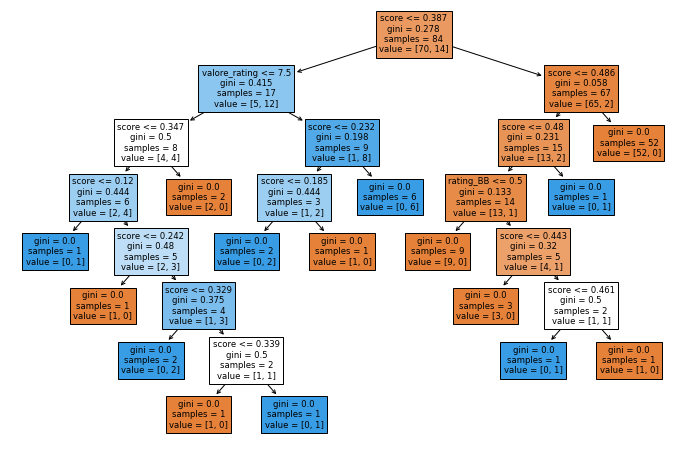

In [27]:
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, filled=True, feature_names=X.columns)
plt.show()

### MOD 1: Random forest 

Passo ad un modello più complesso, ma che mi permette di generalizzare.

In [28]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision   1.0   1.0       1.0        1.0           1.0
recall      1.0   1.0       1.0        1.0           1.0
f1-score    1.0   1.0       1.0        1.0           1.0
support    70.0  14.0       1.0       84.0          84.0
_______________________________________________
Confusion Matrix: 
 [[70  0]
 [ 0 14]]

Test Result:
Accuracy Score: 80.36%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.800000   0.818182  0.803571   0.809091      0.805844
recall      0.947368   0.500000  0.803571   0.723684      0.803571
f1-score    0.867470   0.620690  0.803571   0.744080      0.788148
support    38.000000  18.000000  0.803571  56.000000     56.000000
_______________________________________________
Confusion Matrix: 
 [[36  2]